In [1]:
import math
import random
import matplotlib.pyplot as plt

In [2]:
class BernoulliArm:
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1 if random.random() < self.p else 0

In [24]:
# 확률 기반 선택 함수
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

In [16]:
# Softmax 알고리즘
class Softmax:
    def __init__(self, n_arms, temperature=0.1):
        self.temperature = temperature
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] += (reward - self.values[arm]) / n

In [17]:
# Annealing Softmax
class AnnealingSoftmax:
    def __init__(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 1e-7)
        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values]
        return categorical_draw(probs)
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] += (reward - self.values[arm]) / n

In [18]:
# Epsilon-Greedy
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] += (reward - self.values[arm]) / n

In [25]:
# 실험 실행 함수
def run_experiment(algorithm_class, arms, steps=1000, **kwargs):
    algo = algorithm_class(len(arms), **kwargs)
    rewards = []
    for _ in range(steps):
        arm = algo.select_arm()
        reward = arms[arm].draw()
        algo.update(arm, reward)
        rewards.append(reward)
    return rewards

In [26]:
# 평균 보상 시각화
def plot_avg_rewards(results_dict, title):
    plt.figure(figsize=(10, 6))
    for label, rewards in results_dict.items():
        avg = [sum(rewards[:i])/i for i in range(1, len(rewards))]
        plt.plot(avg, label=label)
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Excercise 1.비슷한 arm들로 실험

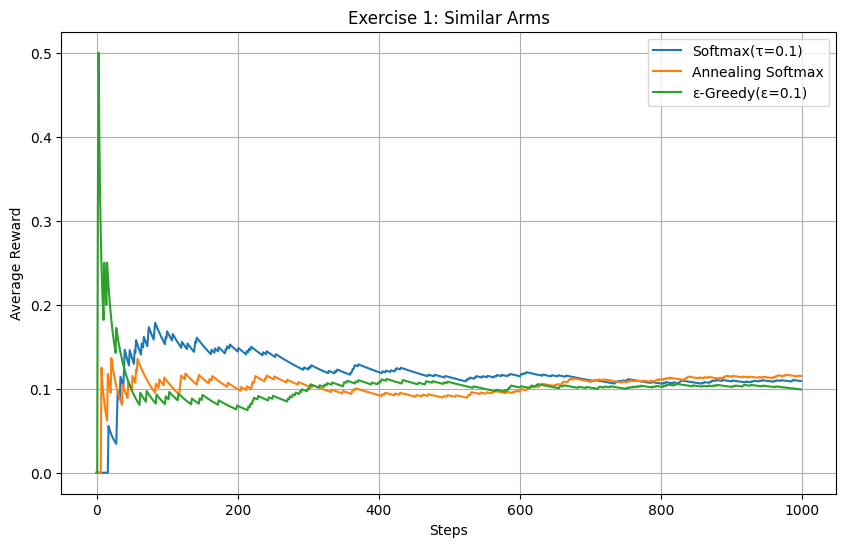

In [27]:
arms_similar = [BernoulliArm(p) for p in [0.1, 0.1, 0.1, 0.1, 0.12]]

results_similar = {
    "Softmax(τ=0.1)": run_experiment(Softmax, arms_similar, temperature=0.1),
    "Annealing Softmax": run_experiment(AnnealingSoftmax, arms_similar),
    "ε-Greedy(ε=0.1)": run_experiment(EpsilonGreedy, arms_similar, epsilon=0.1)
}

plot_avg_rewards(results_similar, "Exercise 1: Similar Arms")


팔의 평균 보상률: [0.1, 0.1, 0.1, 0.1, 0.12]
→ 최적 팔과 다른 팔의 차이가 매우 작음 (0.02)

- 전체 평균 보상률이 0.1 부근에서 수렴
- 이는 모든 알고리즘이 결국 **최적 arm(0.12)**과 비슷한 arm들(0.1)을 자주 선택하고 있기 때문
- arm들 간 차이가 너무 작아서 최적의 팔을 정확히 구분하기 어려움

-> 차이가 작을수록 탐색 전략의 이점이 사라지고, 결과도 비슷해지는 것 아닐까

# Excercise 2. Softmax와 ε-Greedy 유사하게 만들기

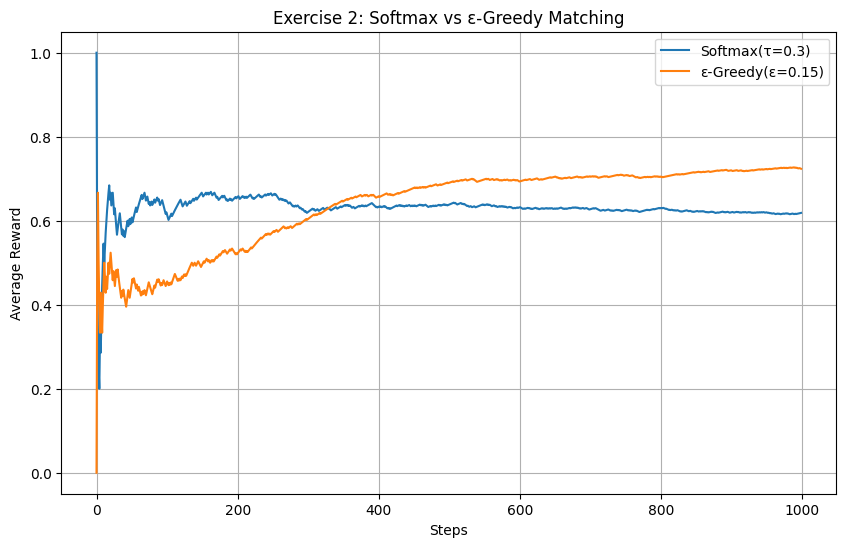

In [28]:
arms_medium = [BernoulliArm(p) for p in [0.2, 0.4, 0.5, 0.6, 0.8]]

results_compare = {
    "Softmax(τ=0.3)": run_experiment(Softmax, arms_medium, temperature=0.3),
    "ε-Greedy(ε=0.15)": run_experiment(EpsilonGreedy, arms_medium, epsilon=0.15)
}

plot_avg_rewards(results_compare, "Exercise 2: Softmax vs ε-Greedy Matching")



Softmax는 reward에 비례한 확률로 선택하므로 초기 정보도 더 잘 활용

반면 ε-Greedy는 완전 무작위 탐색이므로 초기 성능이 불안정

ε = 0.15 이면 85% 확률로 best arm 사용 → 점점 좋은 arm에 집중

Softmax는 τ = 0.3이라 탐색 확률이 줄어들지 않고 고정됨 → 좋은 arm에 덜 집중

# Excercise 3.다양한 Annealing 전략 비교

In [31]:
import math, random
import matplotlib.pyplot as plt

class BernoulliArm:
    def __init__(self, p): self.p = p
    def draw(self): return 1 if random.random() < self.p else 0

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

class CustomAnnealingSoftmax:
    def __init__(self, n_arms, rule="log"):
        self.rule = rule
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        t = sum(self.counts) + 1
        # annealing rule
        if self.rule == "log":
            temperature = 1 / max(math.log(t + 1e-7), 1e-3)
        elif self.rule == "sqrt":
            temperature = 1 / max(math.sqrt(t), 1e-3)
        elif self.rule == "1/t":
            temperature = 1 / max(t, 1e-3)
        elif self.rule == "step":
            temperature = 0.5 if t <= 100 else 0.1
        else:
            temperature = 0.1
        temperature = max(temperature, 1e-2)  # overflow 방지
        # softmax
        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] += (reward - self.values[arm]) / n



In [32]:
def run_experiment(algorithm_class, arms, steps=1000, **kwargs):
    algo = algorithm_class(len(arms), **kwargs)
    rewards = []
    for _ in range(steps):
        arm = algo.select_arm()
        reward = arms[arm].draw()
        algo.update(arm, reward)
        rewards.append(reward)
    return rewards

def plot_avg_rewards(results_dict, title):
    plt.figure(figsize=(10, 6))
    for label, rewards in results_dict.items():
        avg = [sum(rewards[:i]) / i for i in range(1, len(rewards))]
        plt.plot(avg, label=label)
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()


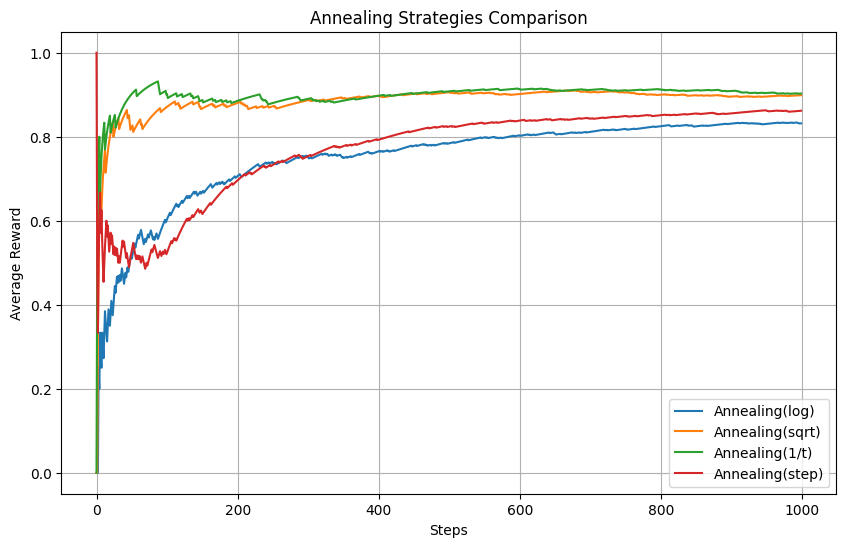

In [33]:
# 팔 구성: 하나만 보상이 높음
arms = [BernoulliArm(p) for p in [0.1, 0.1, 0.1, 0.1, 0.9]]

rules = ["log", "sqrt", "1/t", "step"]
results_annealing = {
    f"Annealing({r})": run_experiment(CustomAnnealingSoftmax, arms, 1000, rule=r)
    for r in rules
}

plot_avg_rewards(results_annealing, "Annealing Strategies Comparison")


1. 1/t: 매우 빠르게 탐색을 줄임
- 초기에는 잘 탐색하고, 빠르게 좋은 arm에 몰입 → 최고 보상 달성

2. sqrt(t): 초반 탐색도 충분하고, 후반에는 exploit 비중을 자연스럽게 높임

3. step : 100회까지는 탐색(τ=0.5), 이후 급격히 exploit(τ=0.1) → 불연속적인 변화

4. log : 탐색이 너무 오래 지속되어 보상이 낮게 유지됨

> Q. 그럼. 언제 log가 효과적일까..?

- arm의 보상률 차이가 작을 때 : 탐색을 오래해야 미묘한 차이를 구별할 수 있음




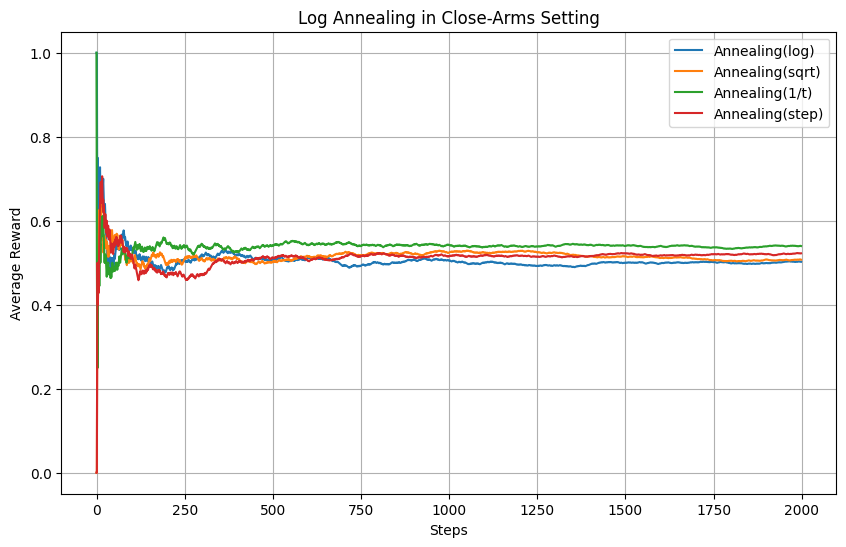

In [35]:
arms_close = [BernoulliArm(p) for p in [0.49, 0.50, 0.51, 0.52, 0.53]]

# Annealing
rules = ["log", "sqrt", "1/t", "step"]
results_close = {
    f"Annealing({r})": run_experiment(CustomAnnealingSoftmax, arms_close, steps=2000, rule=r)
    for r in rules
}

plot_avg_rewards(results_close, "Log Annealing in Close-Arms Setting")


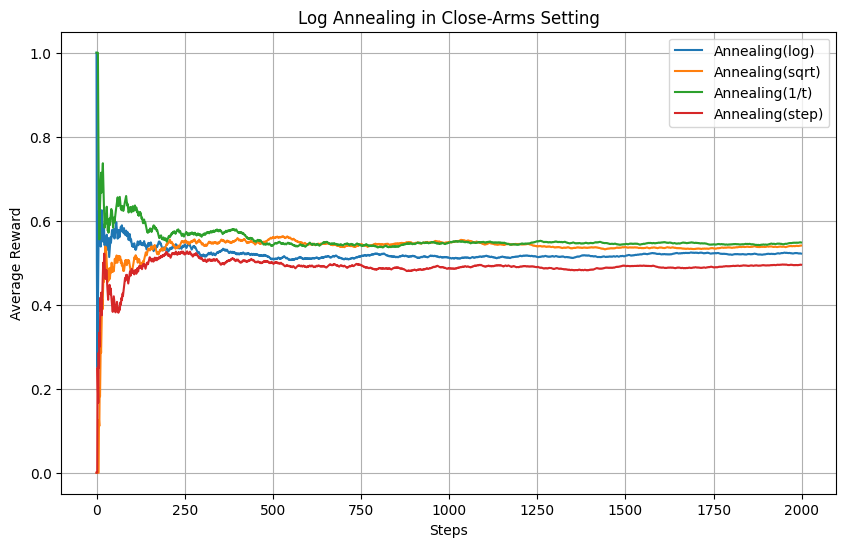

In [37]:
arms_close = [BernoulliArm(p) for p in [0.40, 0.50, 0.45, 0.55, 0.53]]

# Annealing
rules = ["log", "sqrt", "1/t", "step"]
results_close = {
    f"Annealing({r})": run_experiment(CustomAnnealingSoftmax, arms_close, steps=2000, rule=r)
    for r in rules
}

plot_avg_rewards(results_close, "Log Annealing in Close-Arms Setting")

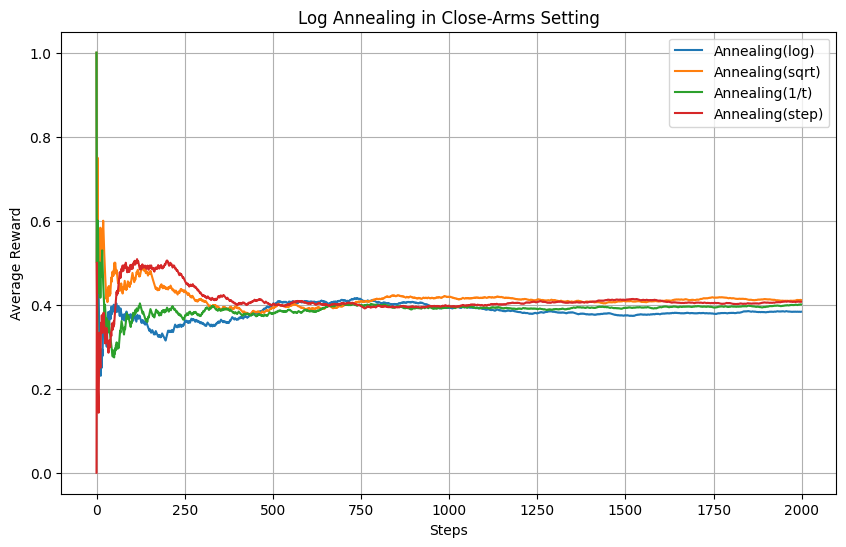

In [38]:
arms_close = [BernoulliArm(p) for p in [0.41, 0.40, 0.41, 0.40, 0.42]]

# Annealing
rules = ["log", "sqrt", "1/t", "step"]
results_close = {
    f"Annealing({r})": run_experiment(CustomAnnealingSoftmax, arms_close, steps=2000, rule=r)
    for r in rules
}

plot_avg_rewards(results_close, "Log Annealing in Close-Arms Setting")